# Hello PyQuantLib

European option pricing with Black-Scholes.

Users familiar with QuantLib-Python (SWIG) will find the API similar.

In [10]:
import pyquantlib as ql

print(f"PyQuantLib {ql.__version__} (QuantLib {ql.__ql_version__})")

PyQuantLib 0.1.0 (QuantLib 1.40)


## Setup

Set the evaluation date and create market data quotes.

In [11]:
# Evaluation date
today = ql.Date(15, 6, 2025)
ql.Settings.instance().evaluationDate = today

# Market data
spot = ql.SimpleQuote(100.0)
rate = ql.SimpleQuote(0.05)
vol = ql.SimpleQuote(0.20)

## Term Structures

In [12]:
dc = ql.Actual365Fixed()

risk_free = ql.FlatForward(today, ql.QuoteHandle(rate), dc)
dividend = ql.FlatForward(today, 0.0, dc)
volatility = ql.BlackConstantVol(today, ql.TARGET(), ql.QuoteHandle(vol), dc)

## Black-Scholes Process

In [13]:
process = ql.GeneralizedBlackScholesProcess(
    ql.QuoteHandle(spot),
    ql.YieldTermStructureHandle(dividend),
    ql.YieldTermStructureHandle(risk_free),
    ql.BlackVolTermStructureHandle(volatility),
)

## Option and Pricing Engine

In [14]:
# European call, strike = 100, 1Y expiry
strike = 100.0
payoff = ql.PlainVanillaPayoff(ql.Call, strike)
exercise = ql.EuropeanExercise(today + ql.Period("1Y"))
option = ql.VanillaOption(payoff, exercise)

# Analytic Black-Scholes
option.setPricingEngine(ql.AnalyticEuropeanEngine(process))

## Results

In [15]:
print(f"NPV:   {option.NPV():.4f}")
print(f"Delta: {option.delta():.4f}")
print(f"Gamma: {option.gamma():.4f}")
print(f"Vega:  {option.vega():.4f}")
print(f"Theta: {option.theta():.4f}")
print(f"Rho:   {option.rho():.4f}")

NPV:   10.4506
Delta: 0.6368
Gamma: 0.0188
Vega:  37.5240
Theta: -6.4140
Rho:   53.2325


## Live Updates

Changing a quote triggers automatic repricing — no need to rebuild anything.

In [16]:
print(f"Spot = {spot.value()}: NPV = {option.NPV():.4f}")

spot.setValue(105.0)
print(f"Spot = {spot.value()}: NPV = {option.NPV():.4f}")

spot.setValue(100.0)  # Reset

Spot = 100.0: NPV = 10.4506
Spot = 105.0: NPV = 13.8579


-5.0

## Spot Ladder

Option value and delta across a wide range of spot prices. The intrinsic value line shows asymptotic convergence for deep ITM/OTM options.

In [17]:
import matplotlib.pyplot as plt

# Wide spot range to show asymptotic behavior
spots = list(range(50, 171, 2))
npvs, deltas, gammas = [], [], []

for s in spots:
    spot.setValue(float(s))
    npvs.append(option.NPV())
    deltas.append(option.delta())
    gammas.append(option.gamma())

spot.setValue(100.0)  # Reset

# Intrinsic value: max(S - K, 0)
intrinsic = [max(s - strike, 0) for s in spots]

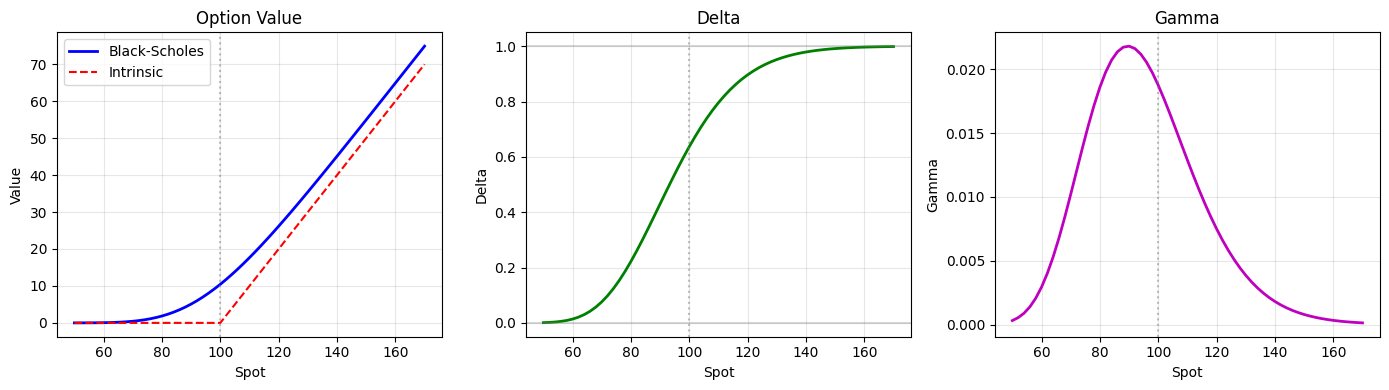

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Option Value vs Intrinsic
axes[0].plot(spots, npvs, 'b-', lw=2, label='Black-Scholes')
axes[0].plot(spots, intrinsic, 'r--', lw=1.5, label='Intrinsic')
axes[0].axvline(strike, color='gray', ls=':', alpha=0.5)
axes[0].set_xlabel('Spot')
axes[0].set_ylabel('Value')
axes[0].set_title('Option Value')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Delta
axes[1].plot(spots, deltas, 'g-', lw=2)
axes[1].axvline(strike, color='gray', ls=':', alpha=0.5)
axes[1].axhline(0, color='gray', ls='-', alpha=0.3)
axes[1].axhline(1, color='gray', ls='-', alpha=0.3)
axes[1].set_xlabel('Spot')
axes[1].set_ylabel('Delta')
axes[1].set_title('Delta')
axes[1].set_ylim(-0.05, 1.05)
axes[1].grid(True, alpha=0.3)

# Gamma
axes[2].plot(spots, gammas, 'm-', lw=2)
axes[2].axvline(strike, color='gray', ls=':', alpha=0.5)
axes[2].set_xlabel('Spot')
axes[2].set_ylabel('Gamma')
axes[2].set_title('Gamma')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()